In [3]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

## Chargement des données
Nous utilisons la base de données MNIST poour entrainer le générateur and le discriminateur. Le générareur va générer des chiffres écrits à la main ressemblant aux données MNIST.

In [7]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [176]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [177]:
BUFFER_SIZE = len(train_images)
BATCH_SIZE = 256

In [178]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [179]:
usps_dataset = tf.data.Dataset.from_tensor_slices(usps_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Modèle

### Le générateur
Le générateur utilise les couches de `tf.keras.layers.Conv2DTranspose` pour produire une image à partir d'une seed (bruit aléatoire). On commence avec une couche Dense qui prend cette seed en input, puis sur-échantillonne (upsample) plusieurs fois jusqu'à atteindre la taille désirée de l'image (28x28x1). On utilise la LeakyReLu (`tf.keras.layers.LeakyReLU`) comme fonction d'activation à chaque couche, sauf pour la couche de sortie où on utilise Tahn.

In [4]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [5]:
generator = generator_model()

noise = tf.random.normal([1, 100])
image = generator(noise, training=False)

In [6]:
image

<tf.Tensor: shape=(1, 28, 28, 1), dtype=float32, numpy=
array([[[[-4.43325145e-04],
         [-8.87677073e-04],
         [ 6.69732108e-04],
         [-2.63264490e-04],
         [ 4.53761872e-03],
         [-7.93361664e-03],
         [ 7.56478403e-04],
         [-8.42688140e-03],
         [-2.72303331e-03],
         [ 2.75753182e-03],
         [-6.93289679e-04],
         [-3.97783238e-03],
         [-1.76433974e-03],
         [-9.74414346e-04],
         [-9.19362996e-04],
         [-6.85152889e-04],
         [-1.87796459e-03],
         [-1.73288938e-02],
         [ 7.19877705e-03],
         [-2.42860755e-03],
         [-1.63239997e-03],
         [-4.78960993e-03],
         [ 6.21944619e-03],
         [ 6.74048578e-03],
         [-6.67163986e-04],
         [-1.38665829e-03],
         [-6.19822228e-03],
         [-1.07442755e-02]],

        [[ 3.63942445e-03],
         [-7.37697631e-03],
         [-1.31958490e-03],
         [-8.77274387e-03],
         [-5.55640145e-04],
         [ 9.68319

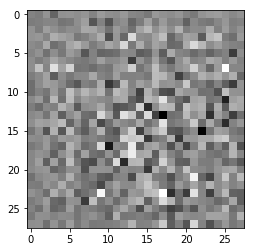

In [199]:
plt.imshow(image[0, :, :, 0], cmap='gray')

### Le discriminateur
Le générateur est un classifieur CNN (Convolutional Neural Network) classique.

In [181]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[16, 16, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

On utilise le discriminateur même s'il n'a pas été entrainé, pour classifier les images générées comme vraies ou fausses. Le modèle s'entrainera pour sortir des valeurs positives pour les vraies images et négatives pour les fausses.

In [159]:
discriminator = discriminator_model()
decision = discriminator(image)
print(decision)

tf.Tensor([[-0.00109924]], shape=(1, 1), dtype=float32)


### Pertes et fonctions d'optimisation

In [160]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Perte du discriminateur
La perte du discriminateur mesure à quel point le discriminateur est capable de distinguer les vraies images des fausses. Il compare les prédictions du discriminateur sur des vraies images à un array de 1, et sur des fausses images à un array de 0.

In [161]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### Perte du générateur
La perte du générateur mesure à quel point le générateyr est capable de tromper le discriminateur. Inuitivement, si le générateur performe bien, le discriminateur va classifier toutes les fausses images comme des vraies. On compare ici les décisions du discriminateur sur les images générées à un array de 1.

In [162]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### Les fonctions d'optimisation
Les fonctions d'optimisation du discriminateur et du générateur diffèrent car on entraine deux réseaux de neurones séparément.

In [163]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Entrainement

In [164]:
EPOCHS = 1
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

Une boucle d'entrainement se déroule en 3 étapes : 
1. Le générateur reçoit la seed aléatoire comme input et l'utilise pour produire une image. 
2. Le discriminateur classifie les vraies images (issues du set d'entrainement) et les fausses images (produites par le générateur). 
3. La perte est calculée pour les deux modèles, et les gradients sont utilisés pour mettre à jour le générateur et le discriminateur.

In [165]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [166]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [167]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Entrainement du modèle
Call the train() method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

In [140]:
train(train_dataset, EPOCHS)

KeyboardInterrupt: 

In [169]:
train(usps_dataset, EPOCHS)

ValueError: in converted code:

    <ipython-input-94-fafdd8657c08>:8 train_step  *
        real_output = discriminator(images, training=True)
    C:\Users\eleon\Anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\base_layer.py:778 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    C:\Users\eleon\Anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\sequential.py:267 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    C:\Users\eleon\Anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\network.py:717 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    C:\Users\eleon\Anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\network.py:891 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    C:\Users\eleon\Anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\base_layer.py:737 __call__
        self.name)
    C:\Users\eleon\Anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\input_spec.py:213 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer dense_8 is incompatible with the layer: expected axis -1 of input shape to have value 6272 but received input with shape [256, 2048]


In [170]:
usps_dataset

<BatchDataset shapes: (None, 16, 16, 1), types: tf.float32>

In [171]:
train_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [55]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### GIF

In [56]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

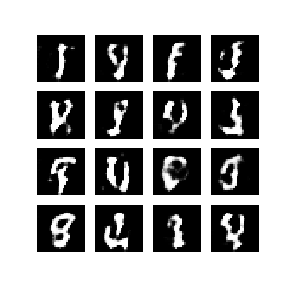

In [58]:
EPOCHS=17
display_image(EPOCHS)

In [61]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)